##Introduction

In this notebook, I'm going to analyze the firefighters interventions in Montreal by boroughs for vehicle related incidents to find out which factors are leading to higher interventions need. two main datasets are going to be used: firefighters inteventions (Interventions des pompiers de Montréal) and road collisions (Collisions routières).

In [2]:
# Import necessary libraries for data manipulation
import pandas as pd
import datetime

In [3]:
# Import necessary libraries for numerical operations, plotting, and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Firefighter Interventions Dataset

In [4]:
# Load the firefighter interventions dataset for the years 2005-2014 from a URL
url = "https://donnees.montreal.ca/dataset/2fc8a2b9-1556-410e-a118-c46e97e9f19e/resource/0a778ac0-9b5a-42cb-8557-167f7f9b8feb/download/donneesouvertes-interventions-sim-2005-2014.csv"
df_5_14 = pd.read_csv(url)

In [4]:
df_5_14.shape

(908486, 11)

In [5]:
# Convert the 'CREATION_DATE_TIME' column to datetime objects for easier time-based analysis
df_5_14['CREATION_DATE_TIME'] = pd.to_datetime(df_5_14['CREATION_DATE_TIME'])

In [6]:
# Load the firefighter interventions dataset for the years 2015-2022 from a URL
url = "https://donnees.montreal.ca/dataset/2fc8a2b9-1556-410e-a118-c46e97e9f19e/resource/005e4eb6-0377-45bf-a911-7077fd3b5ed0/download/donneesouvertes-interventions-sim_2015_2022.csv"
df_15_22 = pd.read_csv(url)

In [ ]:
df_15_22.shape

(894970, 13)

In [7]:
# convert date variable to datetime
df_15_22['CREATION_DATE_TIME'] = pd.to_datetime(df_15_22['CREATION_DATE_TIME'])

In [8]:
# Concatenate the two dataframes to create a single dataframe for the years 2005-2022
df_5_22 = pd.concat([df_5_14, df_15_22])

In [ ]:
df_5_22.shape

(1803456, 13)

In [9]:
# Filter the dataframe to exclude years 2005-2011 and 2022, keeping data from 2012 to 2021
df = df_5_22[(df_5_22['CREATION_DATE_TIME'].dt.year >= 2012) & (df_5_22['CREATION_DATE_TIME'].dt.year <= 2021)]

In [ ]:
df.shape

(1131356, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131356 entries, 560548 to 894967
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   INCIDENT_NBR        1131356 non-null  int64         
 1   CREATION_DATE_TIME  1131356 non-null  datetime64[ns]
 2   INCIDENT_TYPE_DESC  1131356 non-null  object        
 3   DESCRIPTION_GROUPE  1131332 non-null  object        
 4   CASERNE             1131356 non-null  int64         
 5   NOM_VILLE           1131356 non-null  object        
 6   NOM_ARROND          1131356 non-null  object        
 7   DIVISION            1131356 non-null  int64         
 8   LATITUDE            1131356 non-null  float64       
 9   LONGITUDE           1131356 non-null  float64       
 10  NOMBRE_UNITES       1131052 non-null  float64       
 11  MTM8_X              783418 non-null   float64       
 12  MTM8_Y              783418 non-null   float64       
dtypes: datetime64

In [ ]:
# Count records for each unique group in the 'DESCRIPTION_GROUPE' column
df['DESCRIPTION_GROUPE'].value_counts()

,count
DESCRIPTION_GROUPE,
1-REPOND,516194
Premier répondant,233649
SANS FEU,144760
Alarmes-incendies,131238
Sans incendie,60740
AUTREFEU,20589
Autres incendies,10479
INCENDIE,8532
Incendies de bâtiments,3935


In [ ]:
# Number of incidents with more than 100 records for each unique incident type
df['INCIDENT_TYPE_DESC'].value_counts()[df['INCIDENT_TYPE_DESC'].value_counts() > 100]

,count
INCIDENT_TYPE_DESC,
Premier répondant,689794
Appel de Cie de détection,73537
Alarme privé ou locale,51173
Ac.véh./1R/s.v./ext/29B/D,47354
Aliments surchauffés,32643
...,...
Dégag bat./1rép - 22D02,131
Acc. véh victime sfeu - (ext.),130
Sauv. nautique Zone 4,124


In [9]:
# Load the incident type description dataset from a URL. This dataset provides more detailed
# descriptions for the incident type codes found in the main intervention dataset.
url = "https://donnees.montreal.ca/dataset/2fc8a2b9-1556-410e-a118-c46e97e9f19e/resource/4f236894-3fdc-4b04-8d11-80f451ffd70d/download/type-interventions-descriptions20161122.csv"
type_description = pd.read_csv(url)

In [10]:
# List of incident types related to vehicles based on initial data exploration.
vehicle_incident_types = [
    'Ac.véh./1R/s.v./bat/29B/D', 'Ac.véh./1R/s.v./ext/29B/D',
    'Ac.véh./1R/s.v./pont/29B/D', 'Ac.véh./1R/s.v./V.R./29B/D',
    'Ac.véh./s.v./tun/29B/D F7/MOU', 'Acc. sans vict. sfeu - ext.',
    'Acc. sans victime sfeu tunnel', 'Acc. véh victime sfeu - (ext.)',
    'Acc. vict. sfeu tunnel F7/MOU', 'Acc. victime feu - voie rapide',
    'Acc. victime sfeu - bâtiment', 'Acc. victime sfeu - pont',
    'Acc. victime sfeu - voie rap.', 'Acc.véh/1rép/vict/bat 29D04',
    'Acc.véh/1rép/vict/ext 29D04', 'Acc.véh/1rép/vict/pont 29D04',
    'Acc.véh/1rép/vict/tun 29D04 F7', 'Acc.véh/1rép/vict/v.r. 29D04',
    'Feu d\'auto (voie rapide)', 'Feu de véhicule extérieur',
    'Feu de véhicule intérieur', 'Feu de véhicule sur pont',
    'feu de véhicule tunnel F7/MOU', 'Acc. sans vict. sfeu - pont',
    'Surchauffe - véhicule'
]

In [ ]:
# Rename columns in the type_description dataframe for clarity and consistency.
type_description.rename(columns={
    'INCIDENT_TYPE_DESCRIPTION': 'Incident_Type', # Renaming the column containing incident type codes
    'Description': 'Description' # Renaming the column containing the full description
}, inplace=True) # inplace=True modifies the DataFrame directly

In [11]:
# Filter the main dataframe (df) to keep only rows where the 'INCIDENT_TYPE_DESC'
# is present in the predefined list of vehicle-related incident types.
# This creates a subset of the data focusing specifically on vehicle interventions.
vehicle_df = df[df['INCIDENT_TYPE_DESC'].isin(vehicle_incident_types)]

In [ ]:
vehicle_df.shape

(66190, 13)

In [12]:
# Drop columns that are not needed for the subsequent analysis or modeling.
# 'INCIDENT_NBR' is an identifier.
# 'MTM8_X' and 'MTM8_Y' are alternative coordinate systems not used later.
vehicle_df = vehicle_df.drop('INCIDENT_NBR', axis=1)
vehicle_df = vehicle_df.drop('MTM8_X', axis=1)
vehicle_df = vehicle_df.drop('MTM8_Y', axis=1)

In [ ]:
vehicle_df.duplicated().sum()

np.int64(76)

In [13]:
# Drop duplicate rows from the vehicle interventions dataframe
vehicle_df = vehicle_df.drop_duplicates()

In [ ]:
vehicle_df.duplicated().sum()

np.int64(0)

In [14]:
vehicle_df.shape

(66114, 10)

In [ ]:
vehicle_df.tail()

,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,LATITUDE,LONGITUDE,NOMBRE_UNITES,date
894954,2021-12-22,Ac.véh./1R/s.v./V.R./29B/D,1-REPOND,22,Montréal,Saint-Léonard,4,45.582335,-73.588864,3.0,2021-12-22
894955,2021-09-07,Ac.véh./1R/s.v./V.R./29B/D,1-REPOND,73,Montréal,Saint-Laurent,3,45.521240,-73.654596,3.0,2021-09-07
894959,2021-09-03,Ac.véh./1R/s.v./V.R./29B/D,1-REPOND,49,Montréal,Ahuntsic-Cartierville,3,45.550675,-73.629567,3.0,2021-09-03
894960,2021-09-23,Ac.véh./1R/s.v./V.R./29B/D,1-REPOND,28,Montréal,Anjou,4,45.625373,-73.548310,2.0,2021-09-23
894967,2021-07-30,Ac.véh./s.v./tun/29B/D F7/MOU,1-REPOND,20,Montréal,Ville-Marie,6,45.500170,-73.563817,2.0,2021-07-30


In [33]:
# Save the processed vehicle interventions dataframe to a CSV file for potential future use.
vehicle_df.to_csv('vehicle_df.csv', index=False)

In [ ]:
print("\n--- Missing Values ---")
missing_values = vehicle_df.isnull().sum()
print(missing_values)
print(f"\nTotal percentage of missing values: {(vehicle_df.isnull().sum().sum() / (vehicle_df.shape[0] * vehicle_df.shape[1])) * 100:.2f}%")


--- Missing Values ---
CREATION_DATE_TIME    0
INCIDENT_TYPE_DESC    0
DESCRIPTION_GROUPE    0
CASERNE               0
NOM_VILLE             0
NOM_ARROND            0
DIVISION              0
LATITUDE              0
LONGITUDE             0
NOMBRE_UNITES         0
dtype: int64

Total percentage of missing values: 0.00%


In [ ]:
#incidents by year
vehicle_df['CREATION_DATE_TIME'].dt.year.value_counts()

,count
CREATION_DATE_TIME,
2012,8360
2013,8058
2014,7931
2015,7624
2016,6730
2017,6420
2019,6122
2018,6088
2021,5049


In [16]:
vehicle_df['NOM_ARROND'].value_counts()

,count
NOM_ARROND,
Indéterminé,7758
Ville-Marie,5599
Saint-Laurent,4421
Villeray-Saint-Michel-Parc-Extension,3657
Ahuntsic-Cartierville,3440
Montréal-Nord,3286
Saint-Léonard,2990
Côte-des-Neiges-Notre-Dame-de-Grâce,2934
Mercier-Hochelaga-Maisonneuve,2927


In [15]:
# Define a dictionary to map inconsistent borough names to standardized names
borough_name_mapping = {
    'L\'Ile-Bizard / Ste-Geneviève': 'L\'Île-Bizard-Sainte-Geneviève',
    'Pierrefonds / Roxboro': 'Pierrefonds-Roxboro',
    'Lasalle': 'LaSalle',
    'Sud-Ouest': 'Le Sud-Ouest',
    'Ahuntsic / Cartierville': 'Ahuntsic-Cartierville',
    'Côte-des-Neiges / Notre-Dame-de-Grâce': 'Côte-des-Neiges-Notre-Dame-de-Grâce',
    'Plateau Mont-Royal': 'Le Plateau-Mont-Royal',
    'Villeray / St-Michel / Parc Extension': 'Villeray-Saint-Michel-Parc-Extension',
    'Rosemont / Petite-Patrie': 'Rosemont-La Petite-Patrie',
    'Mercier / Hochelaga-Maisonneuve': 'Mercier-Hochelaga-Maisonneuve',
    'Rivière-des-Prairies / Pointe-aux-Trembles': 'Rivière-des-Prairies-Pointe-aux-Trembles'
}

# Replace the inconsistent names in the 'NOM_ARROND' column
vehicle_df['NOM_ARROND'] = vehicle_df['NOM_ARROND'].replace(borough_name_mapping)

# Verify the changes by printing the value counts again
print("Updated borough name counts:")
display(vehicle_df['NOM_ARROND'].value_counts())

Updated borough name counts:


,count
NOM_ARROND,
Indéterminé,7758
Villeray-Saint-Michel-Parc-Extension,5908
Ville-Marie,5599
Ahuntsic-Cartierville,5241
Côte-des-Neiges-Notre-Dame-de-Grâce,4686
Mercier-Hochelaga-Maisonneuve,4518
Saint-Laurent,4421
Rosemont-La Petite-Patrie,3359
Montréal-Nord,3286


In [19]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.2 MB/s eta 0:00:00


In [ ]:
!pip install geopandas contextily

Columns in the Montreal boroughs GeoDataFrame:
Index(['CODEID', 'NOM', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')




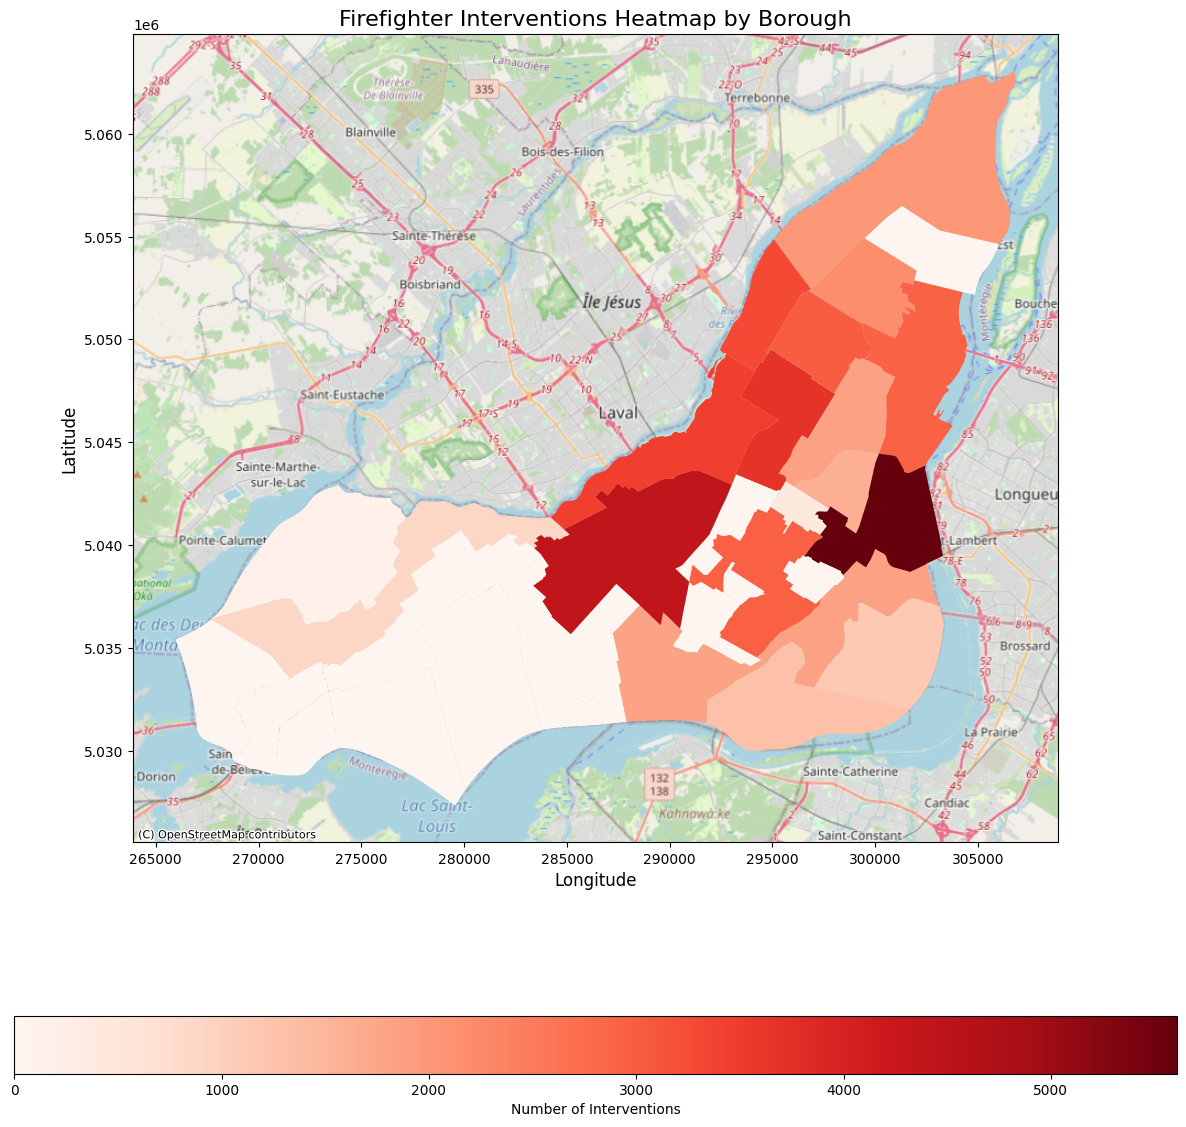

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Assume you have your vehicle_df loaded and cleaned as before
# vehicle_df = ... # your loaded and cleaned vehicle_df

# Path to your downloaded GeoJSON file
# Use the URL directly if it's accessible
boroughs_geojson_path = 'https://donnees.montreal.ca/fr/dataset/9797a946-9da8-41ec-8815-f6b276dec7e9/resource/6b313375-d9bc-4dc3-af8e-ceae3762ae6e/download/limites-administratives-agglomeration-nad83.geojson'

# Read the GeoJSON file into a GeoDataFrame
try:
    montreal_boroughs = gpd.read_file(boroughs_geojson_path)
except Exception as e:
    print(f"Error reading GeoJSON file: {e}")
    print("Please ensure the path to your GeoJSON file is correct and the file is not corrupted or inaccessible.")
    # Exit or handle the error appropriately if the file cannot be read
    exit() # Or use 'continue' if within a larger script

# --- Inspect the column names of the GeoDataFrame (already done, but keeping for reference) ---
print("Columns in the Montreal boroughs GeoDataFrame:")
print(montreal_boroughs.columns)
print("\n")
# ------------------------------------------------------------------------------------------

# Ensure the borough name column in the GeoJSON matches your vehicle_df
# Based on the inspection, 'NOM' or 'NOM_OFFICIEL' are likely candidates
# Let's use 'NOM' for now. If this doesn't work or doesn't match, try 'NOM_OFFICIEL'.
borough_name_column_in_geojson = 'NOM' # <-- **Changed this to 'NOM'**

# Count interventions per borough from your vehicle_df
intervention_counts_by_borough = vehicle_df['NOM_ARROND'].value_counts().reset_index()
intervention_counts_by_borough.columns = ['NOM_ARROND', 'intervention_count']

# Merge intervention counts with borough boundaries
# Ensure the column used for merging ('NOM' from montreal_boroughs and 'NOM_ARROND' from intervention_counts_by_borough) exists and has matching values
borough_intervention_map = montreal_boroughs.merge(intervention_counts_by_borough, left_on=borough_name_column_in_geojson, right_on='NOM_ARROND', how='left')

# Fill boroughs with no interventions with 0 (or NaN if you prefer not to show them)
borough_intervention_map['intervention_count'] = borough_intervention_map['intervention_count'].fillna(0)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the boroughs, colored by the intervention count
# Use a sequential colormap (like 'Reds', 'Blues', 'viridis', etc.) to show intensity
borough_intervention_map.plot(column='intervention_count',
                              ax=ax,
                              legend=True,
                              cmap='Reds', # 'Reds' is a good choice for highlighting higher counts
                              legend_kwds={'label': "Number of Interventions",
                                           'orientation': "horizontal"})

# Add a basemap (optional but recommended)
# Contextily often works best with Web Mercator (EPSG:3857).
# If your borough GeoDataFrame is not in EPSG:3857, you might need to reproject it for accurate basemap alignment.
# Let's check the CRS of the merged GeoDataFrame and use its EPSG code if available, otherwise try reprojecting.
try:
    if borough_intervention_map.crs and borough_intervention_map.crs.to_epsg():
         ctx.add_basemap(ax, crs=borough_intervention_map.crs.to_epsg(), source=ctx.providers.OpenStreetMap.Mapnik)
    else:
        # Reproject to Web Mercator if original CRS is not easily usable with contextily
        print("Original CRS not suitable for basemap. Reprojecting to EPSG:3857.")
        borough_intervention_map_webmercator = borough_intervention_map.to_crs(epsg=3857)
        ax.cla() # Clear the previous plot if reprojecting
        borough_intervention_map_webmercator.plot(column='intervention_count',
                                                  ax=ax,
                                                  legend=True,
                                                  cmap='Reds',
                                                  legend_kwds={'label': "Number of Interventions",
                                                               'orientation': "horizontal"})
        ctx.add_basemap(ax, crs=borough_intervention_map_webmercator.crs.to_epsg(), source=ctx.providers.OpenStreetMap.Mapnik)

except Exception as e:
    print(f"Could not add basemap. Error: {e}")


ax.set_title('Firefighter Interventions Heatmap by Borough', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12) # These labels might not be accurate after reprojection
ax.set_ylabel('Latitude', fontsize=12) # These labels might not be accurate after reprojection

plt.show()

Columns in the Montreal boroughs GeoDataFrame:
Index(['CODEID', 'NOM', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')




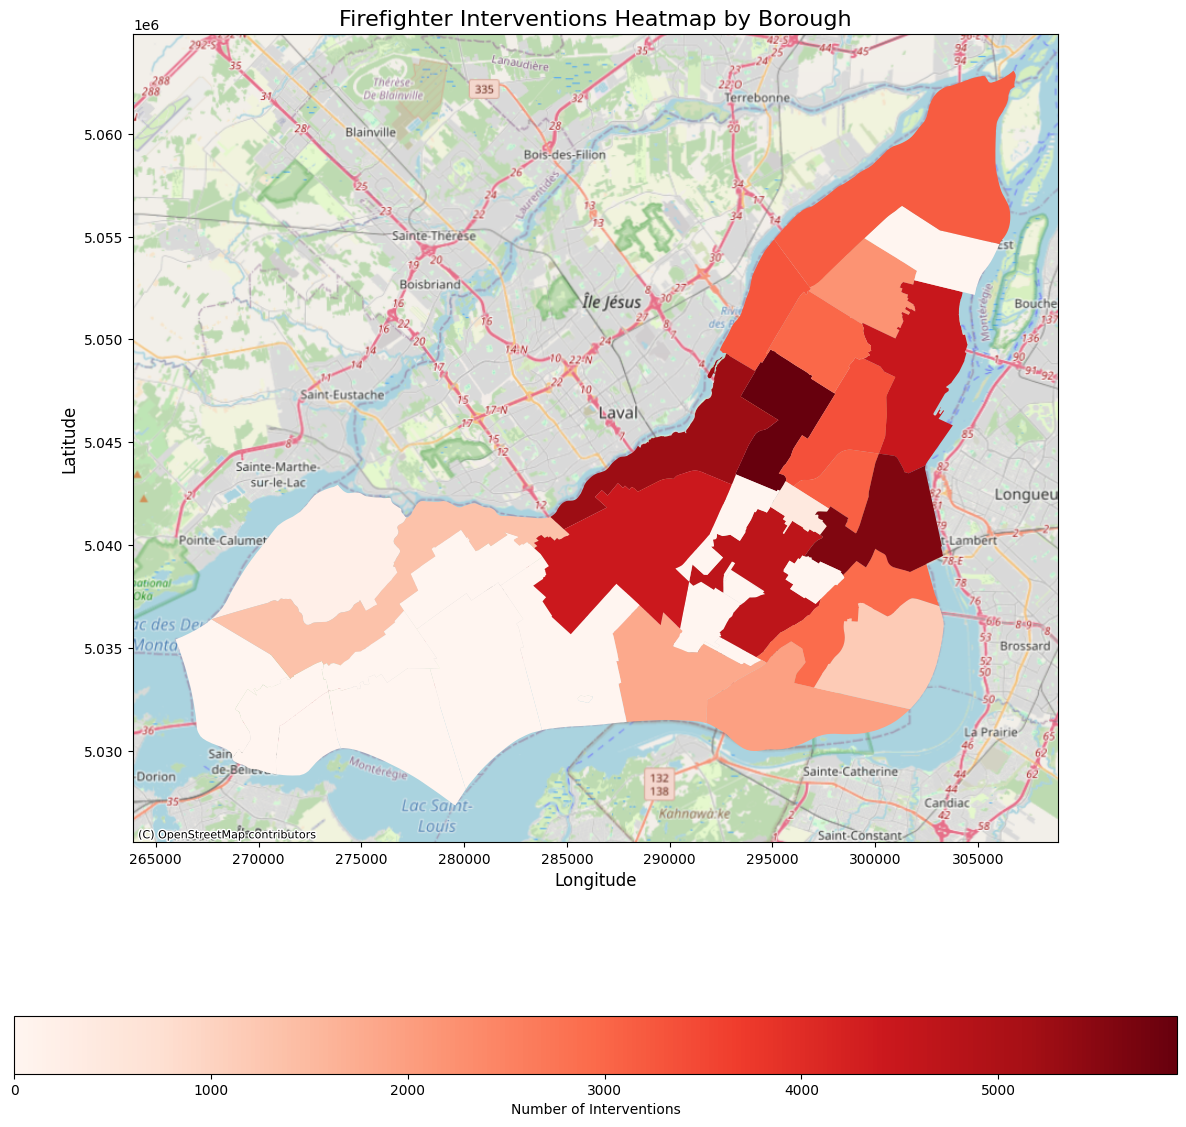

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Assume you have your vehicle_df loaded and cleaned as before
# vehicle_df = ... # your loaded and cleaned vehicle_df

# Path to your downloaded GeoJSON file
# Use the URL directly if it's accessible
boroughs_geojson_path = 'https://donnees.montreal.ca/fr/dataset/9797a946-9da8-41ec-8815-f6b276dec7e9/resource/6b313375-d9bc-4dc3-af8e-ceae3762ae6e/download/limites-administratives-agglomeration-nad83.geojson'

# Read the GeoJSON file into a GeoDataFrame
try:
    montreal_boroughs = gpd.read_file(boroughs_geojson_path)
except Exception as e:
    print(f"Error reading GeoJSON file: {e}")
    print("Please ensure the path to your GeoJSON file is correct and the file is not corrupted or inaccessible.")
    # Exit or handle the error appropriately if the file cannot be read
    exit() # Or use 'continue' if within a larger script

# --- Inspect the column names of the GeoDataFrame (already done, but keeping for reference) ---
print("Columns in the Montreal boroughs GeoDataFrame:")
print(montreal_boroughs.columns)
print("\n")
# ------------------------------------------------------------------------------------------

# Ensure the borough name column in the GeoJSON matches your vehicle_df
# Based on the inspection, 'NOM' or 'NOM_OFFICIEL' are likely candidates
# Let's use 'NOM' for now. If this doesn't work or doesn't match, try 'NOM_OFFICIEL'.
borough_name_column_in_geojson = 'NOM' # <-- **Changed this to 'NOM'**

# Count interventions per borough from your vehicle_df
intervention_counts_by_borough = vehicle_df['NOM_ARROND'].value_counts().reset_index()
intervention_counts_by_borough.columns = ['NOM_ARROND', 'intervention_count']

# Merge intervention counts with borough boundaries
# Ensure the column used for merging ('NOM' from montreal_boroughs and 'NOM_ARROND' from intervention_counts_by_borough) exists and has matching values
borough_intervention_map = montreal_boroughs.merge(intervention_counts_by_borough, left_on=borough_name_column_in_geojson, right_on='NOM_ARROND', how='left')

# Fill boroughs with no interventions with 0 (or NaN if you prefer not to show them)
borough_intervention_map['intervention_count'] = borough_intervention_map['intervention_count'].fillna(0)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the boroughs, colored by the intervention count
# Use a sequential colormap (like 'Reds', 'Blues', 'viridis', etc.) to show intensity
borough_intervention_map.plot(column='intervention_count',
                              ax=ax,
                              legend=True,
                              cmap='Reds', # 'Reds' is a good choice for highlighting higher counts
                              legend_kwds={'label': "Number of Interventions",
                                           'orientation': "horizontal"})

# Add a basemap (optional but recommended)
# Contextily often works best with Web Mercator (EPSG:3857).
# If your borough GeoDataFrame is not in EPSG:3857, you might need to reproject it for accurate basemap alignment.
# Let's check the CRS of the merged GeoDataFrame and use its EPSG code if available, otherwise try reprojecting.
try:
    if borough_intervention_map.crs and borough_intervention_map.crs.to_epsg():
         ctx.add_basemap(ax, crs=borough_intervention_map.crs.to_epsg(), source=ctx.providers.OpenStreetMap.Mapnik)
    else:
        # Reproject to Web Mercator if original CRS is not easily usable with contextily
        print("Original CRS not suitable for basemap. Reprojecting to EPSG:3857.")
        borough_intervention_map_webmercator = borough_intervention_map.to_crs(epsg=3857)
        ax.cla() # Clear the previous plot if reprojecting
        borough_intervention_map_webmercator.plot(column='intervention_count',
                                                  ax=ax,
                                                  legend=True,
                                                  cmap='Reds',
                                                  legend_kwds={'label': "Number of Interventions",
                                                               'orientation': "horizontal"})
        ctx.add_basemap(ax, crs=borough_intervention_map_webmercator.crs.to_epsg(), source=ctx.providers.OpenStreetMap.Mapnik)

except Exception as e:
    print(f"Could not add basemap. Error: {e}")


ax.set_title('Firefighter Interventions Heatmap by Borough', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12) # These labels might not be accurate after reprojection
ax.set_ylabel('Latitude', fontsize=12) # These labels might not be accurate after reprojection

plt.show()

##Collision Road Dataset

In [16]:
# Load the collision dataset from a URL. This dataset contains information about road collisions.
url = "https://donnees.montreal.ca/fr/dataset/cd722e22-376b-4b89-9bc2-7c7ab317ef6b/resource/05deae93-d9fc-4acb-9779-e0942b5e962f/download/collisions_routieres.csv"
df_collision = pd.read_csv(url)

In [ ]:
df_collision.shape

(218272, 68)

In [ ]:
df_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218272 entries, 0 to 218271
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NO_SEQ_COLL                  218272 non-null  object 
 1   JR_SEMN_ACCDN                218272 non-null  object 
 2   DT_ACCDN                     218272 non-null  object 
 3   CD_MUNCP                     218265 non-null  float64
 4   NO_CIVIQ_ACCDN               93491 non-null   float64
 5   SFX_NO_CIVIQ_ACCDN           444 non-null     object 
 6   BORNE_KM_ACCDN               111 non-null     float64
 7   RUE_ACCDN                    205974 non-null  object 
 8   TP_REPRR_ACCDN               135965 non-null  float64
 9   ACCDN_PRES_DE                147189 non-null  object 
 10  NB_METRE_DIST_ACCD           60692 non-null   float64
 11  CD_GENRE_ACCDN               208205 non-null  float64
 12  CD_SIT_PRTCE_ACCDN           5195 non-null    float64
 13 

In [ ]:
df_collision['LOC_IMPRECISION'].value_counts()

,count
LOC_IMPRECISION,
N,199076
O,19196


In [ ]:
df_collision['LOC_DETACHEE'].value_counts()

,count
LOC_DETACHEE,
N,182514
O,35739


In [ ]:
df_collision['CD_ZON_TRAVX_ROUTR'].value_counts()

,count
CD_ZON_TRAVX_ROUTR,
2.0,3055
1.0,1836
0.0,13


The 'CD_ZON_TRAVX_ROUTR' shows if there is roadwork:
1. Upstream area of the roadwork where drivers are informed of lane changes, speed reductions, passing restrictions, etc.
2. Zone where there are changes to the road layout or the speed limit to allow for the work, or where there are mobile works taking place.

So, it's woth to keep this variable and consider non values as 'non roadwork'.

In [17]:
df_collision['CD_SIT_PRTCE_ACCDN'].value_counts()

,count
CD_SIT_PRTCE_ACCDN,
9.0,2188
1.0,1471
3.0,1359
2.0,177


The 'CD_SIT_PRTCE_ACCDN' shows particular conditions:
1. spillage: vehicle transporting a liquid load loses this load
2. Load loss: When a vehicle transporting a solid load loses this load

In [17]:
# Define a list of columns that are considered unuseful or redundant for the analysis.
extra_variables = [
                  'NO_SEQ_COLL', # Sequence number (identifier)
                  'AN', # Year (already handled by datetime conversion)
                  'CD_PNT_CDRNL_ROUTE', # Cardinal point of the road (often missing or not directly useful)
                  'NO_ROUTE', # Route number (often missing or not directly useful)
                  'BORNE_KM_ACCDN', # Kilometric marker (often missing)
                  'SFX_NO_CIVIQ_ACCDN', # Suffix of civic number (not generally useful for analysis)
                  'LOC_Y', # Y coordinate (redundant after creating geometry for GeoDataFrame)
                  'LOC_X' # X coordinate (redundant after creating geometry for GeoDataFrame)
                  ]

In [18]:
#drop extra variables
df_collision = df_collision.drop(extra_variables, axis=1)

In [ ]:
df_collision.shape

(218272, 60)

In [ ]:
df_collision.duplicated().sum()

np.int64(175)

In [19]:
#drop duplicate
df_collision = df_collision.drop_duplicates()

In [ ]:
df_collision.duplicated().sum()

np.int64(0)

In [20]:
df_collision.shape

(218097, 60)

In [ ]:
#df_collision to csv
df_collision.to_csv('df_collision.csv', index=False)

In [ ]:
df_collision['GRAVITE'].value_counts()

,count
GRAVITE,
Dommages matériels inférieurs au seuil de rapportage,86964
Dommages matériels seulement,83166
Léger,45919
Grave,1785
Mortel,263


##Analyze on Borough level

In [52]:
import pandas as pd
import numpy as np
import geopandas as gpd

# --- Part 1: Load All Necessary Datasets ---
print("Phase 1: Loading all source datasets...")
try:
    collisions_df = df_collision.copy()
    interventions_df = vehicle_df.copy()
    print("Collision and intervention data loaded successfully.")
except FileNotFoundError as e:
    print(f"FATAL ERROR: {e}. Please ensure source CSV files are uploaded.")
    exit()

# Load the borough boundaries directly from the web
boroughs_url = "https://donnees.montreal.ca/fr/dataset/9797a946-9da8-41ec-8815-f6b276dec7e9/resource/6b313375-d9bc-4dc3-af8e-ceae3762ae6e/download/limites-administratives-agglomeration-nad83.geojson"
try:
    boroughs_gdf = gpd.read_file(boroughs_url)
    print("Borough boundaries GeoJSON loaded successfully.")
except Exception as e:
    print(f"FATAL ERROR: Could not load borough data from the web. {e}")
    exit()


# --- Part 2: Prepare Data and Perform Spatial Joins ---
print("\nPhase 2: Preparing data for spatial join...")
# Prepare collisions data
collisions_df['DT_ACCDN'] = pd.to_datetime(collisions_df['DT_ACCDN'], errors='coerce')
collisions_df.dropna(subset=['DT_ACCDN', 'LOC_LONG', 'LOC_LAT'], inplace=True)
collisions_df['year_month'] = collisions_df['DT_ACCDN'].dt.to_period('M').astype(str)
collisions_gdf = gpd.GeoDataFrame(
    collisions_df, geometry=gpd.points_from_xy(collisions_df.LOC_LONG, collisions_df.LOC_LAT), crs="EPSG:4326"
)

# Prepare interventions data
interventions_df['CREATION_DATE_TIME'] = pd.to_datetime(interventions_df['CREATION_DATE_TIME'], errors='coerce')
interventions_df.dropna(subset=['CREATION_DATE_TIME', 'LONGITUDE', 'LATITUDE'], inplace=True)
interventions_df['year_month'] = interventions_df['CREATION_DATE_TIME'].dt.to_period('M').astype(str)
interventions_gdf = gpd.GeoDataFrame(
    interventions_df, geometry=gpd.points_from_xy(interventions_df.LONGITUDE, interventions_df.LATITUDE), crs="EPSG:4326"
)

# Ensure all GeoDataFrames use the same projection
boroughs_gdf = boroughs_gdf.to_crs(collisions_gdf.crs)

# Perform the spatial joins
print("Performing spatial joins to assign events to boroughs...")
collisions_in_boroughs = gpd.sjoin(collisions_gdf, boroughs_gdf, how="inner", predicate='within')
interventions_in_boroughs = gpd.sjoin(interventions_gdf, boroughs_gdf, how="inner", predicate='within')
print("Spatial joins complete.")


# --- Part 3: Memory-Optimized Feature Engineering by Borough ---
print("\nPhase 3: Performing exhaustive, memory-optimized feature engineering...")

# Create a base dataframe for merging, starting with a simple count
base_agg_df = collisions_in_boroughs.groupby(['NOM', 'year_month']).size().reset_index(name='collision_count')

# Batch A: Vehicle and Victim Counts
print("Aggregating vehicle and victim counts...")
sum_cols = [col for col in collisions_in_boroughs.columns if 'nb_' in col.lower() or 'NB_' in col.lower()]
agg_vehicles_victims = collisions_in_boroughs.groupby(['NOM', 'year_month'])[sum_cols].sum().reset_index()
base_agg_df = pd.merge(base_agg_df, agg_vehicles_victims, on=['NOM', 'year_month'], how='outer')

# Batch B, C, D, etc.: Categorical Features
categorical_features = {
    'CD_COND_METEO': 'weather', 'CD_ETAT_SURFC': 'surface', 'CD_ECLRM': 'lighting', 'GRAVITE': 'severity',
    'CD_GENRE_ACCDN': 'accdn_type', 'CD_LOCLN_ACCDN': 'location_type', 'CD_CONFG_ROUTE': 'road_config',
    'CD_ENVRN_ACCDN': 'accdn_environment', 'CD_ZON_TRAVX_ROUTR': 'roadwork', 'CD_SIT_PRTCE_ACCDN': 'spillage'
}

for col, prefix in categorical_features.items():
    if col in collisions_in_boroughs.columns:
        print(f"Aggregating counts for {prefix}...")
        dummies = pd.get_dummies(collisions_in_boroughs[col], prefix=prefix, dummy_na=True)
        dummies[['NOM', 'year_month']] = collisions_in_boroughs[['NOM', 'year_month']]
        agg_cat = dummies.groupby(['NOM', 'year_month']).sum().reset_index()
        base_agg_df = pd.merge(base_agg_df, agg_cat, on=['NOM', 'year_month'], how='outer')

# --- Part 4: Final Merge and Save ---
print("\nPhase 4: Merging with intervention data and finalizing...")

# Aggregate intervention data
monthly_interventions = interventions_in_boroughs.groupby(['NOM', 'year_month']).agg(
    intervention_count=('NOMBRE_UNITES', 'size'),
    firefighter_risk_score=('NOMBRE_UNITES', 'sum')
).reset_index()
final_borough_df = pd.merge(base_agg_df, monthly_interventions, on=['NOM', 'year_month'], how='outer')

# Add the collision risk score
severity_weights = {'Mortel': 10, 'Grave': 5, 'Léger': 2, 'Dommages matériels seulement': 1, 'Dommages matériels inférieurs au seuil de rapportage': 1}
collisions_in_boroughs['collision_risk_score'] = collisions_in_boroughs['GRAVITE'].map(severity_weights).fillna(0)
collision_risk_agg = collisions_in_boroughs.groupby(['NOM', 'year_month'])['collision_risk_score'].sum().reset_index()
final_borough_df = pd.merge(final_borough_df, collision_risk_agg, on=['NOM', 'year_month'], how='left')

# Final cleanup
final_borough_df.fillna(0, inplace=True)


print("\n--- Final Detailed Borough-Level Monthly Dataset (v2) ---")
print(f"Dataset created with {final_borough_df.shape[0]} rows and {final_borough_df.shape[1]} columns.")
print("Each row represents the total statistics for a borough during a specific month and year.")
print(final_borough_df.head())

# Save the new dataset
#final_borough_df.to_csv('borough_detailed_monthly_data.csv', index=False)
#print("\nFinal dataset saved to 'borough_detailed_monthly_data.csv'")

Phase 1: Loading all source datasets...
Collision and intervention data loaded successfully.
Borough boundaries GeoJSON loaded successfully.

Phase 2: Preparing data for spatial join...
Performing spatial joins to assign events to boroughs...
Spatial joins complete.

Phase 3: Performing exhaustive, memory-optimized feature engineering...
Aggregating vehicle and victim counts...
Aggregating counts for weather...
Aggregating counts for surface...
Aggregating counts for lighting...
Aggregating counts for severity...
Aggregating counts for accdn_type...
Aggregating counts for location_type...
Aggregating counts for road_config...
Aggregating counts for accdn_environment...
Aggregating counts for roadwork...
Aggregating counts for spillage...

Phase 4: Merging with intervention data and finalizing...

--- Final Detailed Borough-Level Monthly Dataset (v2) ---
Dataset created with 3875 rows and 139 columns.
Each row represents the total statistics for a borough during a specific month and yea

In [ ]:
final_borough_df.shape

(3875, 139)

In [22]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66114 entries, 560599 to 894967
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CREATION_DATE_TIME  66114 non-null  datetime64[ns]
 1   INCIDENT_TYPE_DESC  66114 non-null  object        
 2   DESCRIPTION_GROUPE  66114 non-null  object        
 3   CASERNE             66114 non-null  int64         
 4   NOM_VILLE           66114 non-null  object        
 5   NOM_ARROND          66114 non-null  object        
 6   DIVISION            66114 non-null  int64         
 7   LATITUDE            66114 non-null  float64       
 8   LONGITUDE           66114 non-null  float64       
 9   NOMBRE_UNITES       66114 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 5.5+ MB


In [ ]:
borough_risk_totals = final_borough_df.groupby('NOM')['firefighter_risk_score'].sum().sort_values(ascending=False)
borough_risk_totals

,firefighter_risk_score
NOM,
Ville-Marie,11258.0
Villeray-Saint-Michel-Parc-Extension,10466.0
Saint-Laurent,10013.0
Ahuntsic-Cartierville,9850.0
Côte-des-Neiges-Notre-Dame-de-Grâce,9135.0
Mercier-Hochelaga-Maisonneuve,8136.0
Rivière-des-Prairies-Pointe-aux-Trembles,5925.0
Le Sud-Ouest,5897.0
Rosemont-La Petite-Patrie,5887.0


###Model development

In [21]:
# Import necessary libraries for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [53]:
final_borough_df['year_month'] = pd.to_datetime(final_borough_df['year_month'])

In [54]:
final_borough_df['month'] = final_borough_df['year_month'].dt.month

In [55]:
#get dummies on month
# Dropped the original 'month' column after creating dummies to avoid duplication issues
final_borough_df = pd.get_dummies(final_borough_df, columns=['month'], prefix='month', drop_first=False) # Keep all month columns for now, but ensure unique names

# Ensure column names are unique after get_dummies
final_borough_df.columns = pd.unique(final_borough_df.columns)

In [56]:
# --- Part 2: Add the Categorical Risk Level Variable ---
print("\nPhase 2: Adding the 'intervention_risk_level' column...")

# Define the threshold based on the 75th percentile
threshold = 50 # This threshold was determined based on analysis (e.g., 75th percentile of firefighter_risk_score)
print(f"Using threshold of {threshold} to define risk levels.")

# Create the new column using a simple condition
# np.where is a fast and efficient way to do this
final_borough_df['intervention_risk_level'] = np.where(
    final_borough_df['firefighter_risk_score'] > threshold,
    'High Risk',
    'Low Risk'
)

print("Categorical variable created successfully.")


# --- Part 3: Display and Save the Result ---
print("\n--- Distribution of the New Risk Level Variable ---")
print(final_borough_df['intervention_risk_level'].value_counts())

print("\n--- Final Dataset with Risk Levels (Sample) ---")
# Show a sample including the new column
print(final_borough_df[['NOM', 'year_month', 'firefighter_risk_score', 'intervention_risk_level']].head())


Phase 2: Adding the 'intervention_risk_level' column...
Using threshold of 50 to define risk levels.
Categorical variable created successfully.

--- Distribution of the New Risk Level Variable ---
intervention_risk_level
Low Risk     2915
High Risk     960
Name: count, dtype: int64

--- Final Dataset with Risk Levels (Sample) ---
                     NOM year_month  firefighter_risk_score  \
0  Ahuntsic-Cartierville 2012-01-01                    69.0   
1  Ahuntsic-Cartierville 2012-02-01                    59.0   
2  Ahuntsic-Cartierville 2012-03-01                    75.0   
3  Ahuntsic-Cartierville 2012-04-01                    59.0   
4  Ahuntsic-Cartierville 2012-05-01                    78.0   

  intervention_risk_level  
0               High Risk  
1               High Risk  
2               High Risk  
3               High Risk  
4               High Risk  


In [57]:
from sklearn.preprocessing import LabelEncoder

# --- Part 2: Build and Train the Random Forest Model ---
print("\nPhase 2: Building Random Forest model...")

# Define Target (y) and Features (X)
target_col_str = 'intervention_risk_level'

# Encode the string target variable (y) into numbers
le = LabelEncoder()
final_borough_df['target_encoded'] = le.fit_transform(final_borough_df[target_col_str])
print(f"Target labels encoded: {list(le.classes_)}")

# The features are all other columns, except identifiers and other risk scores/direct outputs.
# Define features to drop based on the analysis and the need to avoid leakage.
features_to_drop = [
    'NOM',  # Identifier
    'year_month',  # Date identifier
    'collision_count',  # Direct count, potential leakage
    'collision_risk_score',  # Direct risk score, potential leakage
    'firefighter_risk_score',  # Target variable's source
    'intervention_count', # Direct count, potential leakage
    'NB_METRE_DIST_ACCD', # Unclear utility and high missing values
    'nb_autres_types', # Low variance/utility
    'nb_veh_non_precise', # Low variance/utility
    'nb_automobile_camion_leger', # Included in NB_VEH_IMPLIQUES_ACCDN
    'NB_VEH_IMPLIQUES_ACCDN', # Direct component of risk
    'NB_BLESSES_LEGERS', # Direct component of risk
    'NB_VICTIMES_TOTAL', # Direct component of risk
    'NB_MORTS', # Direct component of risk
    'NB_BLESSES_GRAVES', # Direct component of risk
    'nb_camionLourd_tractRoutier', # Low variance/utility
    'nb_outil_equipement', # Low variance/utility
    'nb_tous_autobus_minibus', # Low variance/utility
    'nb_bicyclette', # Low variance/utility
    'nb_cyclomoteur', # Low variance/utility
    'nb_motocyclette', # Low variance/utility
    'nb_taxi', # Low variance/utility
    'nb_urgence', # Low variance/utility
    'nb_motoneige', # Low variance/utility
    'nb_VHR', # Low variance/utility
    'NB_DECES_PIETON', # Direct component of risk
    'NB_BLESSES_PIETON', # Direct component of risk
    'NB_VICTIMES_PIETON', # Direct component of risk
    'NB_DECES_MOTO', # Direct component of risk
    'NB_BLESSES_MOTO', # Direct component of risk
    'NB_VICTIMES_MOTO', # Direct component of risk
    'NB_DECES_VELO', # Direct component of risk
    'NB_BLESSES_VELO', # Direct component of risk
    'NB_VICTIMES_VELO', # Direct component of risk
    'severity_Dommages matériels inférieurs au seuil de rapportage', # Derived from GRAVITE, potential leakage
    'severity_Dommages matériels seulement', # Derived from GRAVITE, potential leakage
    'severity_Grave', # Derived from GRAVITE, potential leakage
    'severity_Léger', # Derived from GRAVITE, potential leakage
    'severity_Mortel', # Derived from GRAVITE, potential leakage
    'severity_nan', # Derived from GRAVITE, potential leakage
    'spillage_nan', # Derived from CD_SIT_PRTCE_ACCDN
    'roadwork_nan', # Derived from CD_ZON_TRAVX_ROUTR
    'intervention_risk_level', # The original target string column
    'target_encoded' # The encoded target column
]
# Ensure all feature names are strings for scikit-learn compatibility
X = final_borough_df.drop(columns=features_to_drop, errors='ignore') # Use errors='ignore' in case some columns were already dropped
X.columns = [str(col) for col in X.columns]

# Define target variable y
y = final_borough_df['target_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training on {len(X.columns)} features...")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Phase 2: Building Random Forest model...
Target labels encoded: ['High Risk', 'Low Risk']
Training on 109 features...
Training set shape: (2906, 109)
Testing set shape: (969, 109)


####Random Forest

In [39]:
# Initialize and train the Random Forest model
print("Training Random Forest model...")
rfc = RandomForestClassifier(n_estimators=100,
                               random_state=42,
                               n_jobs=-1,
                               class_weight='balanced') # Use class_weight to handle imbalance
rfc.fit(X_train, y_train)
print("Random Forest model training complete.")

Training Random Forest model...
Random Forest model training complete.



Evaluating Random Forest classifier performance on training set...
Overall Accuracy (Train): 1.0000

Classification Report (Train):
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00       720
    Low Risk       1.00      1.00      1.00      2186

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


Confusion Matrix (Train):


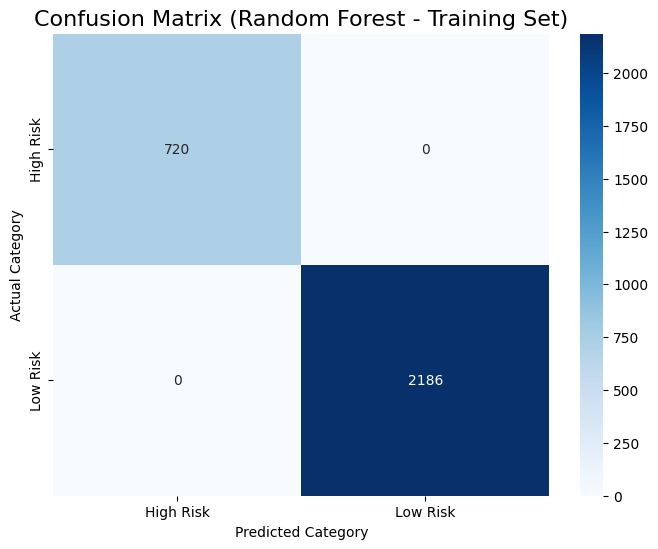

In [ ]:
# --- Evaluate the Random Forest Model on Training Set ---
print("\nEvaluating Random Forest classifier performance on training set...")
y_pred_train_rfc = rfc.predict(X_train)

# Print Accuracy
print(f"Overall Accuracy (Train): {accuracy_score(y_train, y_pred_train_rfc):.4f}")

# Print detailed Classification Report
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_rfc, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Train):")
cm_train_rfc = confusion_matrix(y_train, y_pred_train_rfc, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_rfc, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest - Training Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Evaluating Random Forest classifier performance on test set...
Overall Accuracy (Test): 0.9164

Classification Report (Test):
              precision    recall  f1-score   support

   High Risk       0.86      0.79      0.82       240
    Low Risk       0.93      0.96      0.95       729

    accuracy                           0.92       969
   macro avg       0.90      0.87      0.88       969
weighted avg       0.91      0.92      0.92       969


Confusion Matrix (Test):


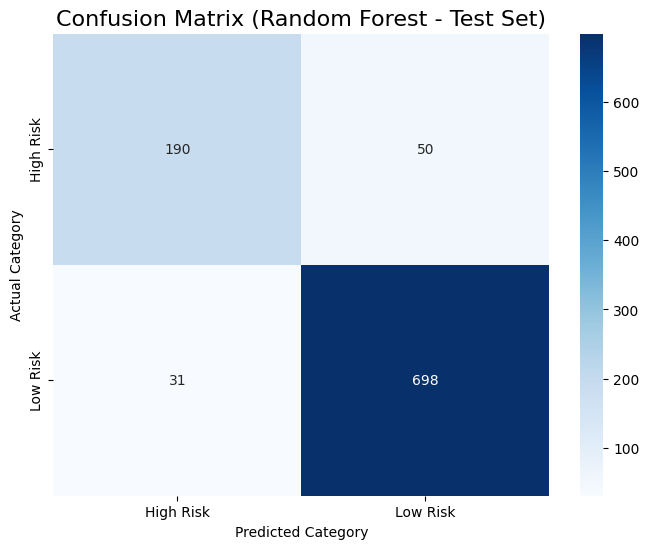

In [40]:
# --- Evaluate the Random Forest Model on Test Set ---
print("\nEvaluating Random Forest classifier performance on test set...")
y_pred_test_rfc = rfc.predict(X_test)

# Print Accuracy
print(f"Overall Accuracy (Test): {accuracy_score(y_test, y_pred_test_rfc):.4f}")

# Print detailed Classification Report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_rfc, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Test):")
cm_test_rfc = confusion_matrix(y_test, y_pred_test_rfc, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_rfc, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest - Test Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Extracting top 20 feature importances for Random Forest...


/tmp/ipython-input-65-3716689826.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_rfc, palette='viridis')


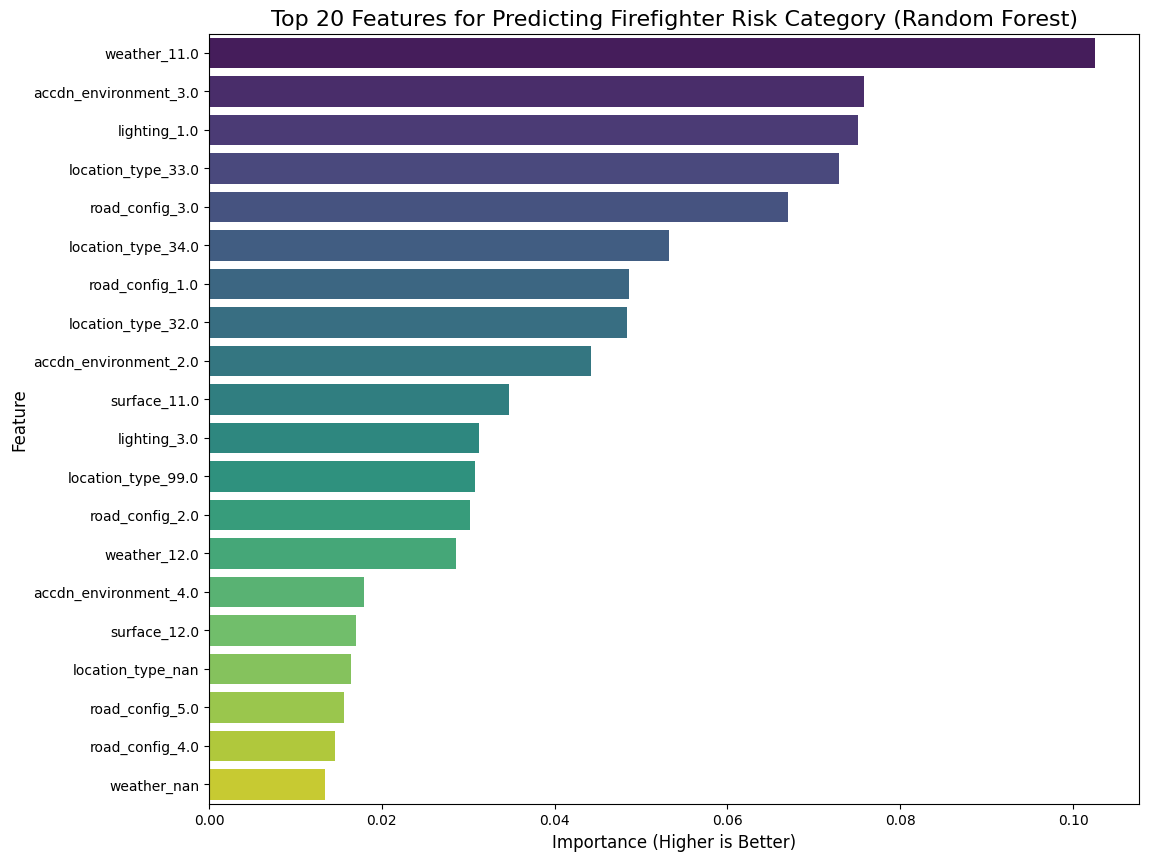

In [ ]:
# --- Interpret the Random Forest Model: Top 20 Feature Importances ---
print("\nExtracting top 20 feature importances for Random Forest...")
feature_importances_rfc = pd.DataFrame({
    'feature': X.columns,
    'importance': rfc.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances_rfc, palette='viridis')
plt.title('Top 20 Features for Predicting Firefighter Risk Category (Random Forest)', fontsize=16)
plt.xlabel('Importance (Higher is Better)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

####LightGBM

In [30]:
import lightgbm as lgb

In [31]:
# Initialize and train the LGBMClassifier model
print("Training LightGBM model...")
lgbmodel = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
lgbmodel.fit(X_train, y_train)
print("LightGBM model training complete.")

Training LightGBM model...
[LightGBM] [Info] Number of positive: 2186, number of negative: 720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 2906, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM model training complete.



Evaluating LightGBM classifier performance on training set...
Overall Accuracy (Train): 1.0000

Classification Report (Train):
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00       720
    Low Risk       1.00      1.00      1.00      2186

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


Confusion Matrix (Train):


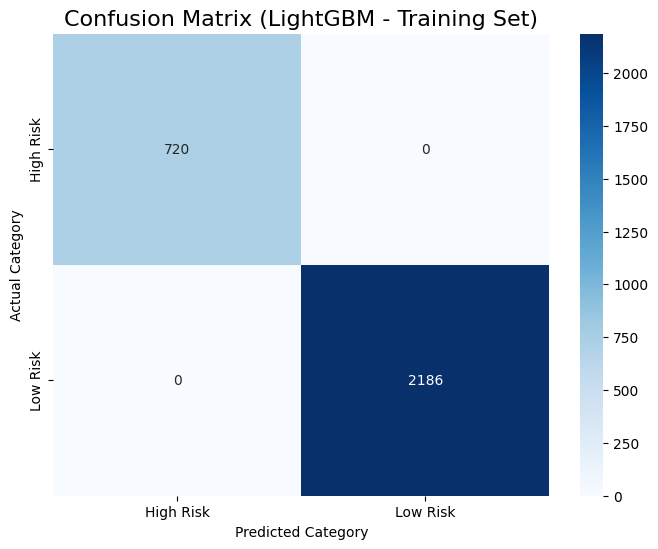

In [ ]:
# --- Evaluate the LightGBM Model on Training Set ---
print("\nEvaluating LightGBM classifier performance on training set...")
y_pred_train_lgbm = lgbmodel.predict(X_train)

# Print Accuracy
print(f"Overall Accuracy (Train): {accuracy_score(y_train, y_pred_train_lgbm):.4f}")

# Print detailed Classification Report
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_lgbm, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Train):")
cm_train_lgbm = confusion_matrix(y_train, y_pred_train_lgbm, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (LightGBM - Training Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Evaluating LightGBM classifier performance on test set...
Overall Accuracy (Test): 0.9288

Classification Report (Test):
              precision    recall  f1-score   support

   High Risk       0.85      0.86      0.86       240
    Low Risk       0.95      0.95      0.95       729

    accuracy                           0.93       969
   macro avg       0.90      0.91      0.90       969
weighted avg       0.93      0.93      0.93       969


Confusion Matrix (Test):


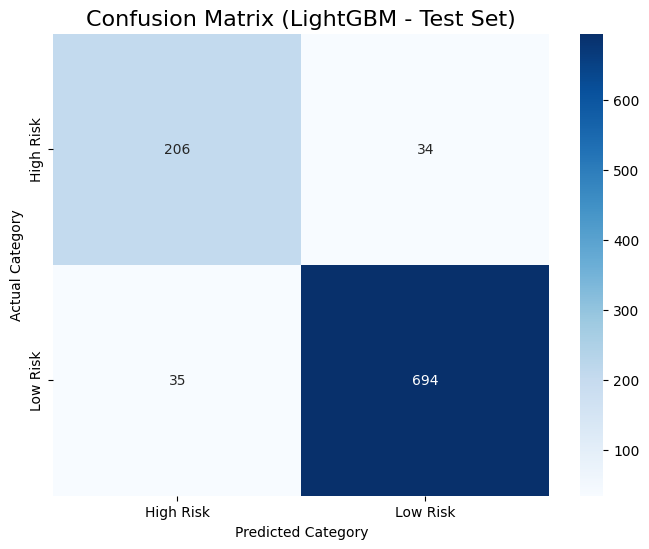

In [32]:
# --- Evaluate the LightGBM Model on Test Set ---
print("\nEvaluating LightGBM classifier performance on test set...")
y_pred_test_lgbm = lgbmodel.predict(X_test)

# Print Accuracy
print(f"Overall Accuracy (Test): {accuracy_score(y_test, y_pred_test_lgbm):.4f}")
# Print detailed Classification Report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_lgbm, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Test):")
cm_test_lgbm = confusion_matrix(y_test, y_pred_test_lgbm, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (LightGBM - Test Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Extracting top 20 feature importances for LightGBM...


/tmp/ipython-input-33-3079837739.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_lgbm, palette='mako')


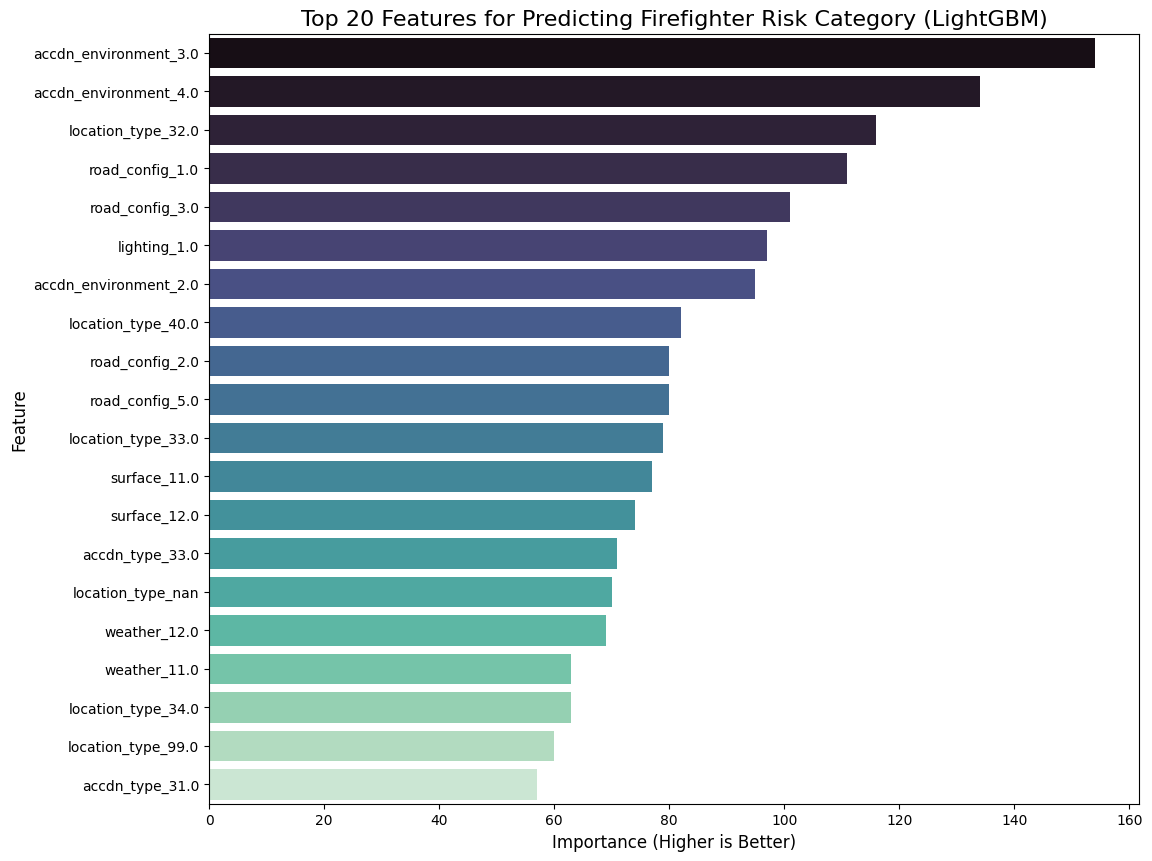

In [33]:
# --- Interpret the LightGBM Model: Top 20 Feature Importances ---
print("\nExtracting top 20 feature importances for LightGBM...")
feature_importances_lgbm = pd.DataFrame({
    'feature': X.columns,
    'importance': lgbmodel.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances_lgbm, palette='mako')
plt.title('Top 20 Features for Predicting Firefighter Risk Category (LightGBM)', fontsize=16)
plt.xlabel('Importance (Higher is Better)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

####XGBoost

In [41]:
# Load the xgboost library
import xgboost as xgb

In [58]:
# Initialize and train the XGBoost model
# Note: class_weight is not directly supported in XGBoost. Using scale_pos_weight for imbalance.
# We'll calculate scale_pos_weight based on the training data.
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count if pos_count > 0 else 1

print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(random_state=42,
                              scale_pos_weight=scale_pos_weight_value, # Handle class imbalance
                              use_label_encoder=False, # Recommended to avoid a future warning
                              eval_metric='logloss', # Recommended metric for classification
                              n_jobs=-1)
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:45:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training complete.



Evaluating XGBoost classifier performance on training set...
Overall Accuracy (Train): 1.0000

Classification Report (Train):
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00       720
    Low Risk       1.00      1.00      1.00      2186

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


Confusion Matrix (Train):


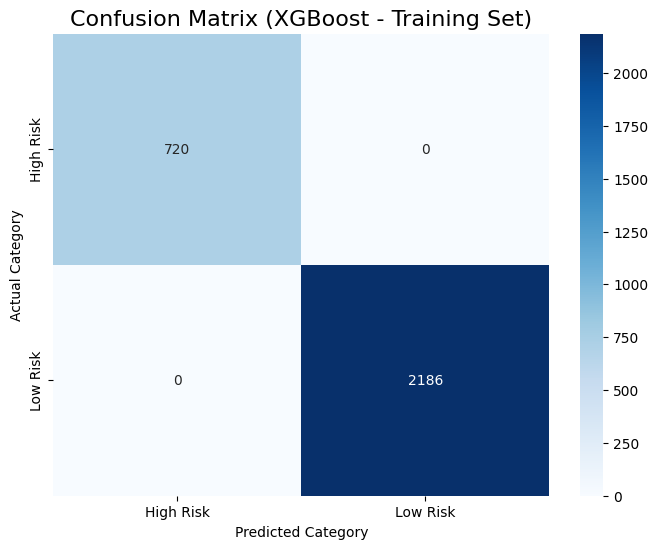

In [ ]:
# --- Evaluate the XGBoost Model on Training Set ---
print("\nEvaluating XGBoost classifier performance on training set...")
y_pred_train_xgb = xgb_model.predict(X_train)

# Print Accuracy
print(f"Overall Accuracy (Train): {accuracy_score(y_train, y_pred_train_xgb):.4f}")

# Print detailed Classification Report
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_xgb, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Train):")
cm_train_xgb = confusion_matrix(y_train, y_pred_train_xgb, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (XGBoost - Training Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Evaluating XGBoost classifier performance on test set...
Overall Accuracy (Test): 0.9216

Classification Report (Test):
              precision    recall  f1-score   support

   High Risk       0.84      0.85      0.84       240
    Low Risk       0.95      0.95      0.95       729

    accuracy                           0.92       969
   macro avg       0.89      0.90      0.90       969
weighted avg       0.92      0.92      0.92       969


Confusion Matrix (Test):


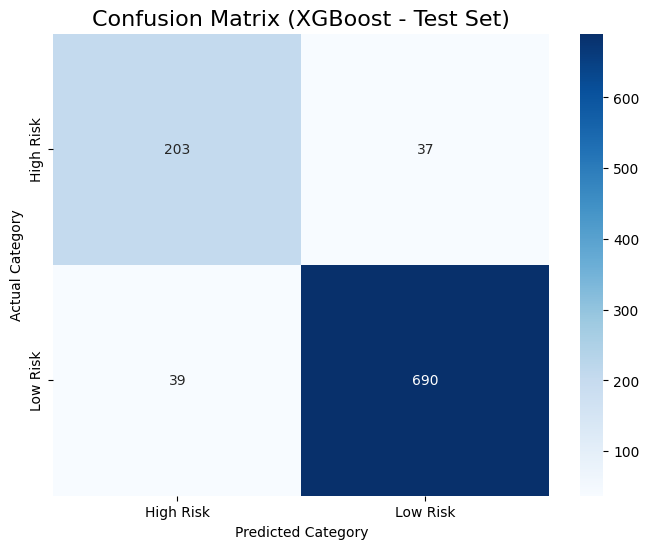

In [59]:
# --- Evaluate the XGBoost Model on Test Set ---
print("\nEvaluating XGBoost classifier performance on test set...")
y_pred_test_xgb = xgb_model.predict(X_test)

# Print Accuracy
print(f"Overall Accuracy (Test): {accuracy_score(y_test, y_pred_test_xgb):.4f}")
# Print detailed Classification Report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_xgb, target_names=le.classes_))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Test):")
cm_test_xgb = confusion_matrix(y_test, y_pred_test_xgb, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (XGBoost - Test Set)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Extracting top 20 feature importances for XGBoost...


/tmp/ipython-input-60-508839687.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_xgb, palette='mako')


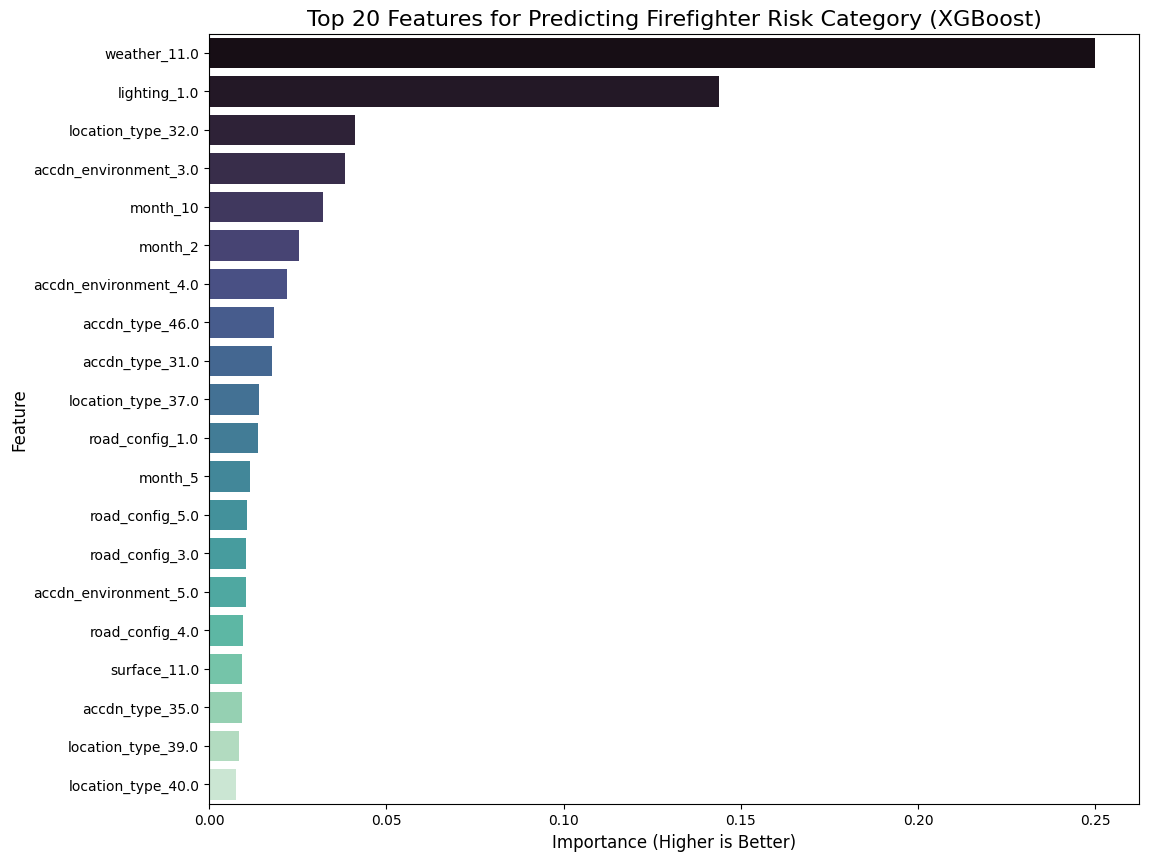

In [60]:
# --- Interpret the XGBoost Model: Top 20 Feature Importances ---
print("\nExtracting top 20 feature importances for XGBoost...")
feature_importances_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances_xgb, palette='mako')
plt.title('Top 20 Features for Predicting Firefighter Risk Category (XGBoost)', fontsize=16)
plt.xlabel('Importance (Higher is Better)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

##Model selection and fine tuning

As the LightGBM outperforms other models in terms of recall, which is more important for us, we're going to use this model as a base for further analyses including feature selection, fine tuning, etc.

###fine tuning

####select non-zero feature importance

In [80]:
# --- Optimization Stage 1: Feature Selection ---
print("\n--- Optimization Stage 1: Feature Selection ---")
# Train a baseline model to get feature importances
baseline_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
baseline_model.fit(X_train, y_train)
importances = pd.DataFrame({'feature': X_train.columns, 'importance': baseline_model.feature_importances_})
# Identify features with zero importance
zero_importance_features = importances[importances['importance'] == 0]['feature'].tolist()
print(f"Found {len(zero_importance_features)} features with zero importance. They will be removed.")

# Create new training and testing sets with selected features
X_train_selected = X_train.drop(columns=zero_importance_features)
X_test_selected = X_test.drop(columns=zero_importance_features)
print(f"Number of features reduced from {X_train.shape[1]} to {X_train_selected.shape[1]}.")

# Train a new model on the selected features and evaluate
print("\nTraining model on selected features...")
model_selected_features = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
model_selected_features.fit(X_train_selected, y_train)
y_pred_selected = model_selected_features.predict(X_test_selected)
print("\nClassification Report (After Feature Selection):")
print(classification_report(y_test, y_pred_selected, target_names=le.classes_))


--- Optimization Stage 1: Feature Selection ---
[LightGBM] [Info] Number of positive: 2186, number of negative: 720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 2906, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Found 18 features with zero importance. They will be removed.
Number of features reduced from 109 to 91.

Training model on selected features...
[LightGBM] [Info] Number of positive: 2186, number of negative: 720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

####gridsearch cv

In [76]:
# Import necessary libraries for hyperparameter tuning and evaluation metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, recall_score, roc_auc_score, f1_score
import warnings # Import warnings to manage potential warnings during grid search

In [84]:
# Ignore warnings during grid search to keep the output clean
warnings.filterwarnings('ignore')

# --- Optimization Stage 2: Hyperparameter Tuning ---
print("\n--- Optimization Stage 2: Hyperparameter Tuning ---")
print("This step can take several minutes...")

# Define the parameter grid to search for the LightGBM model
# This is a small grid for demonstration. For a real project, you might test more values.
param_grid = {
    'n_estimators': [100, 200], # Number of boosting rounds
    'learning_rate': [0.05, 0.1], # Step size shrinkage used in update to prevent overfitting
    'num_leaves': [6, 31, 50], # Maximum tree leaves for the base learners
    'max_depth': [-1, 10], # Maximum tree depth for the base learners, -1 means no limit
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]

}
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 10],
    'subsample': [0.8, 0.9],      # <-- Add this
    'colsample_bytree': [0.8, 0.9] # <-- Add this
}
# Define scorers for multiple metrics
# Get the integer label for 'High Risk' using the fitted LabelEncoder
high_risk_label = le.transform(['High Risk'])[0]


# Create a scorer that focuses on the F1-score of the 'High Risk' class
scorer = make_scorer(recall_score, pos_label=high_risk_label)

# Set up GridSearchCV to find the best hyperparameters
# We will use the feature-selected data (X_train_selected, y_train) for tuning
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1), # Use balanced class weight
    param_grid=param_grid, # The parameters to search over
    scoring=scorer, # The evaluation metrics to evaluate
    cv=3, # Use 3-fold cross-validation
    refit='Recall_HighRisk', # Specify which metric to optimize for and refit the best estimator
    verbose=2 # Display progress messages
)

# Run the grid search on the training data
grid_search.fit(X_train_selected, y_train)

# Print the best parameters found by GridSearchCV
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print the cross-validation results for all evaluated metrics
#print("\nGridSearchCV results:")
#display(pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_Recall_HighRisk').head())


# Evaluate the best model found by the grid search on the test set
print("\nEvaluating the best model from tuning on the test set...")
best_model = grid_search.best_estimator_ # Get the best model found by grid search
y_pred_tuned = best_model.predict(X_test_selected) # Make predictions on the test set

# Print the classification report for the tuned model
print("\nClassification Report (After Tuning):")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

# Also evaluate ROC AUC on the test set using the best model
y_pred_proba_tuned = best_model.predict_proba(X_test_selected)[:, high_risk_label] # Get probabilities for the High Risk class
test_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)
print(f"\nROC AUC Score (Test Set): {test_roc_auc:.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


Evaluating tuned classifier performance on test set...
Overall Accuracy: 0.9205

Classification Report:
              precision    recall  f1-score   support

   High Risk       0.82      0.88      0.85       240
    Low Risk       0.96      0.94      0.95       729

    accuracy                           0.92       969
   macro avg       0.89      0.91      0.90       969
weighted avg       0.92      0.92      0.92       969


Confusion Matrix:


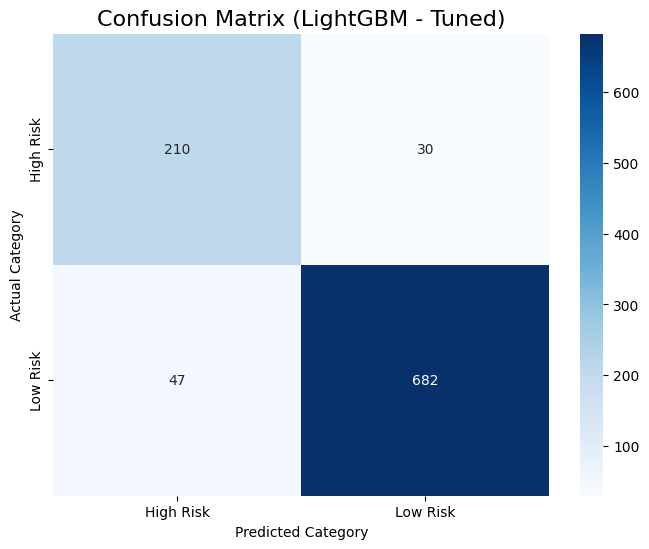

In [85]:
# --- Evaluate the Tuned Model on Test Set ---
print("\nEvaluating tuned classifier performance on test set...")
y_pred = best_model.predict(X_test_selected)
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=le.transform(le.classes_))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (LightGBM - Tuned)', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()


Extracting top 20 feature importances from the tuned model...


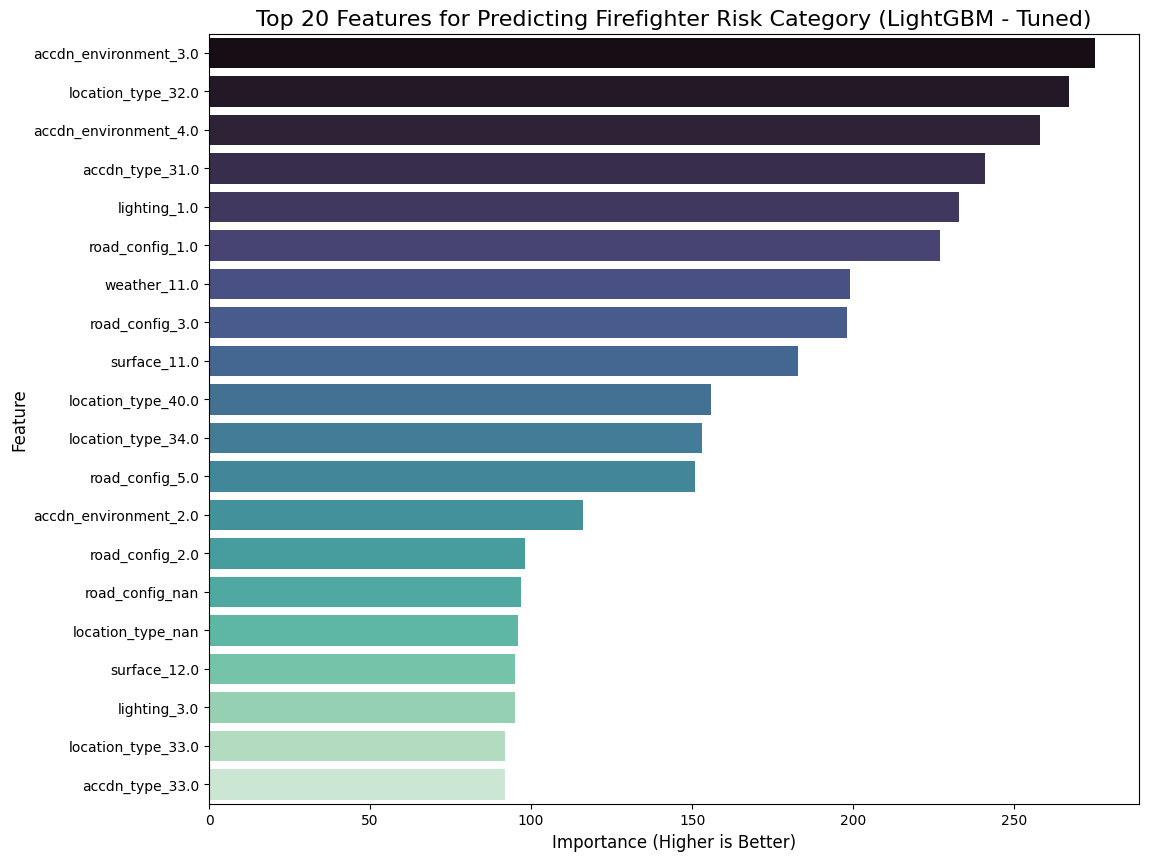

In [86]:
# --- Interpret the Tuned Model: Top 20 Feature Importances ---
print("\nExtracting top 20 feature importances from the tuned model...")
feature_importances = pd.DataFrame({
    'feature': X_train_selected.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='mako')
plt.title('Top 20 Features for Predicting Firefighter Risk Category (LightGBM - Tuned)', fontsize=16)
plt.xlabel('Importance (Higher is Better)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

###SHAP Analysis

In [87]:
# Attempt to import SHAP, handle if not installed
try:
    import shap
    print("SHAP library loaded successfully.")
except ImportError:
    print("FATAL ERROR: The 'shap' library is required for this analysis.")
    print("Please install it by running: pip install shap")
    exit()

import warnings # Import warnings to manage potential warnings
warnings.filterwarnings('ignore') # Ignore warnings during SHAP analysis

SHAP library loaded successfully.



Phase 3: Generating SHAP explanations for top high-risk instances...
Shape of shap_values: (2906, 91)
Type of shap_values: <class 'numpy.ndarray'>
Expected value: 2.4340502348222275
Type of expected_value: <class 'numpy.float64'>

--- Risk Profile for Top High-Risk Instance #1 ---
Borough: Ville-Marie, Month: 2016-05-01 00:00:00


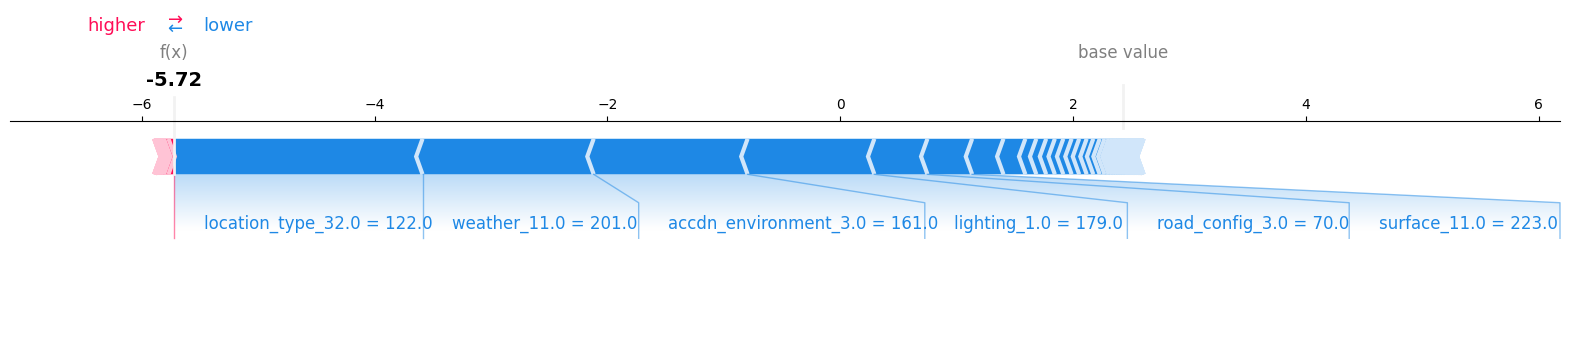

None


--- Risk Profile for Top High-Risk Instance #2 ---
Borough: Ville-Marie, Month: 2015-09-01 00:00:00


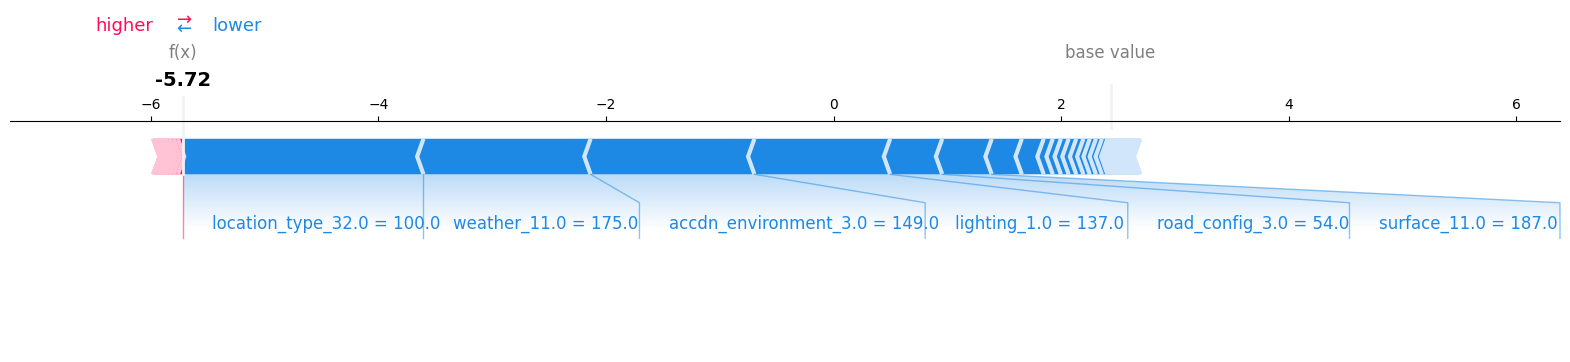

None


--- Risk Profile for Top High-Risk Instance #3 ---
Borough: Villeray-Saint-Michel-Parc-Extension, Month: 2015-07-01 00:00:00


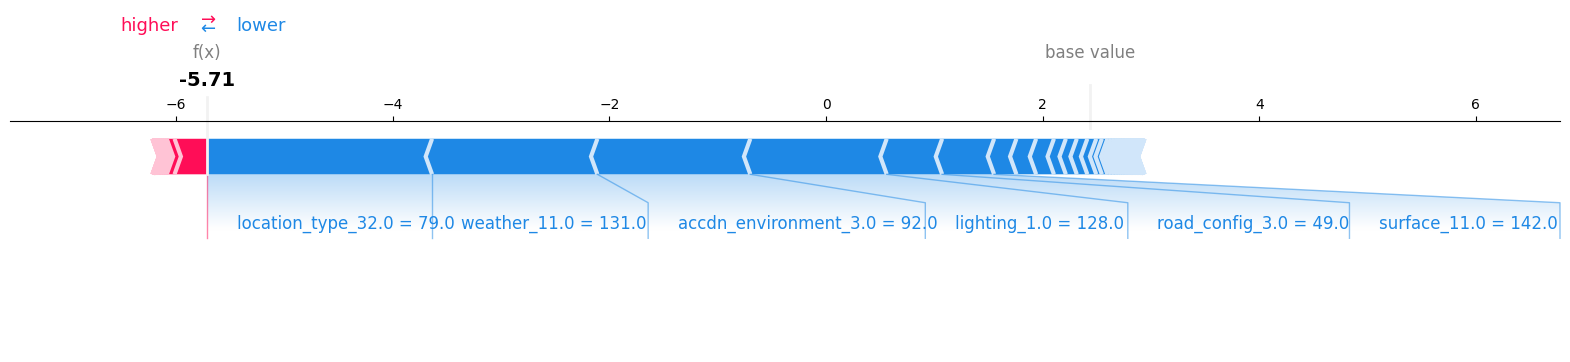

None

In [88]:
# --- Part 3: Generate SHAP Explanations ---
print("\nPhase 3: Generating SHAP explanations for top high-risk instances...")

# Create a SHAP explainer object using the best tuned model
explainer = shap.TreeExplainer(best_model)
# Calculate SHAP values for the training data with selected features
# This can be computationally intensive for large datasets
shap_values = explainer.shap_values(X_train_selected)

# --- Debugging: Print shape and type of shap_values and expected_value ---
print("Shape of shap_values:", [s.shape for s in shap_values] if isinstance(shap_values, list) else shap_values.shape)
print("Type of shap_values:", type(shap_values))
print("Expected value:", explainer.expected_value)
print("Type of expected_value:", type(explainer.expected_value))
# --- End Debugging ---


# Get the predicted probabilities for the "High Risk" class from the training set
high_risk_label_index = list(le.classes_).index('High Risk')
pred_probabilities = best_model.predict_proba(X_train_selected)[:, high_risk_label_index]

# Find the indices of the top 3 instances in the training set with the highest probability of being "High Risk"
top_3_indices = np.argsort(pred_probabilities)[-3:]

# Generate a force plot for each of the top 3 instances
# Force plots help visualize how each feature contributes to the prediction for a single instance
for i, instance_index in enumerate(reversed(top_3_indices)): # Reverse to show #1 first (highest probability)
    print(f"\n--- Risk Profile for Top High-Risk Instance #{i+1} ---")
    # Need to get the original data index to retrieve borough and month for context
    original_index = X_train_selected.iloc[instance_index].name
    borough = final_borough_df.loc[original_index, 'NOM']
    date = final_borough_df.loc[original_index, 'year_month']
    print(f"Borough: {borough}, Month: {date}")

    # Display the force plot
    # Use the scalar expected_value directly and index the single shap_values array (since it's a binary classifier)
    display(shap.force_plot(
        explainer.expected_value,  # Use the scalar expected_value directly
        shap_values[instance_index,:], # SHAP values for the current instance from the single array
        X_train_selected.iloc[instance_index,:], # Feature values for this instance
        matplotlib=True # Use matplotlib backend for displaying in Colab
    ))


Generating SHAP Summary Plot...


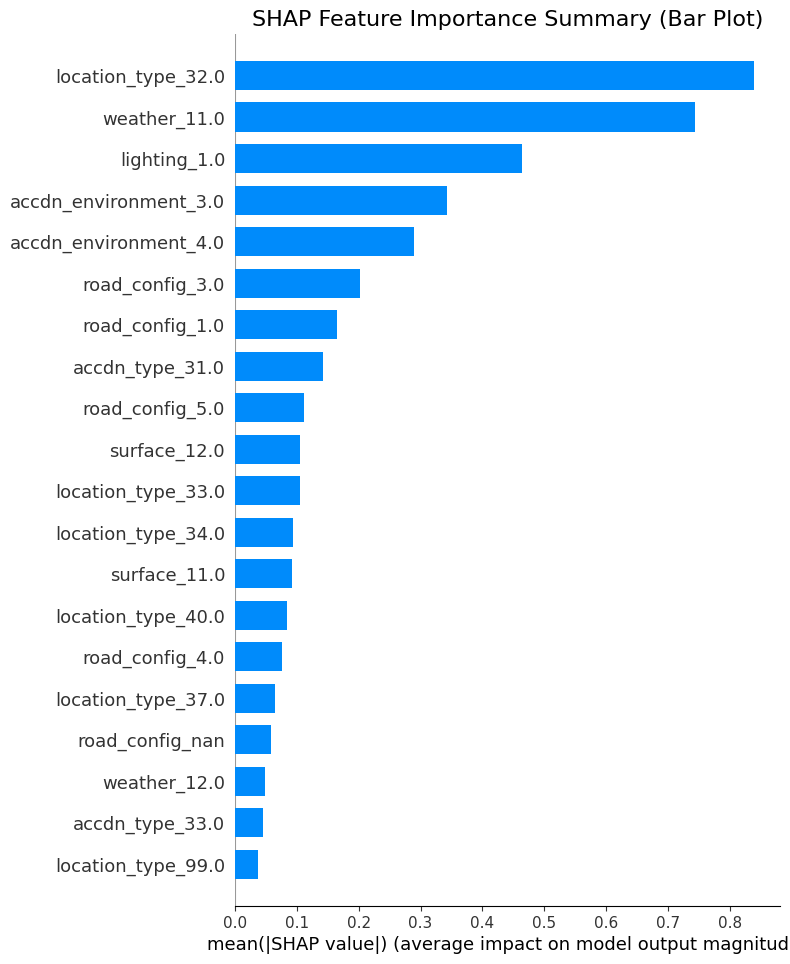

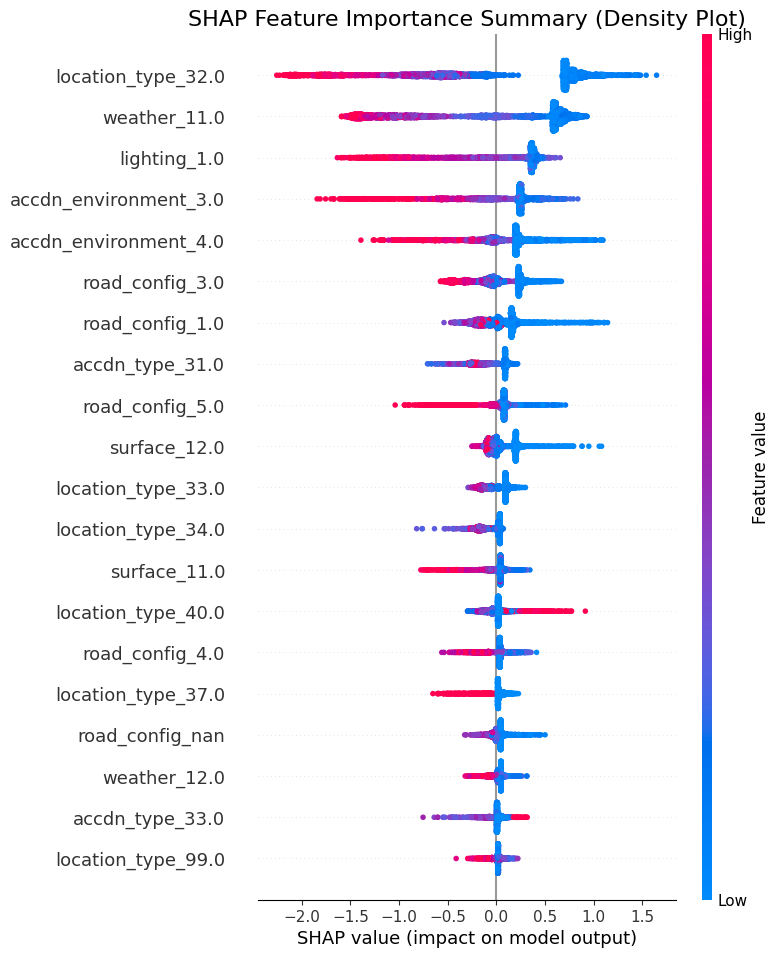

In [89]:
# --- Generate SHAP Summary Plot ---
print("\nGenerating SHAP Summary Plot...")

# Check if shap_values is a list (multi-output model) or a single array (single-output model)
# Adjust indexing accordingly for plotting
if isinstance(shap_values, list):
    # For multi-output models, choose the SHAP values for the target class (e.g., 'High Risk')
    # Assuming 'High Risk' is the class of interest, find its index
    high_risk_class_index = list(le.classes_).index('High Risk')
    shap_values_for_summary = shap_values[high_risk_class_index]
else:
    # For single-output models (like binary classification), shap_values is already the array we need
    shap_values_for_summary = shap_values

# Display the summary plot as a bar chart
# This plot shows the average impact of each feature on the model output magnitude
shap.summary_plot(shap_values_for_summary, X_train_selected, plot_type="bar", show=False)
plt.title('SHAP Feature Importance Summary (Bar Plot)', fontsize=16)
plt.show()

# For a different perspective, a density plot can also be informative
# This plot shows the distribution of SHAP values for each feature, indicating how
# feature values (color) relate to their impact (position on the x-axis)
shap.summary_plot(shap_values_for_summary, X_train_selected, show=False)
plt.title('SHAP Feature Importance Summary (Density Plot)', fontsize=16)
plt.show()